[NbConvertApp] Converting notebook outage_bunching.ipynb to script
[NbConvertApp] Writing 9571 bytes to outage_bunching.py


EX: -0.3020812629615438 mX: -3.262791873823303 B: -89.24211904142203
total bunching -0.32347439315455523
EX: 8.308873745105332 mX: -14.214969322291198 B: 2648.020789135148
total bunching 12.156995276646507
EX: 2.4314265747849837 mX: 2.418291888789241 B: 1045.804181617038
total bunching 3.220253870118228
deltaX: 1.0750935934714858
total bunching 0.20402852095843785
deltaX: 3.1784042177717065
total bunching 21.222889594842897
deltaX: 2.6161394640675932
total bunching 0.985919418343619
True
True
True


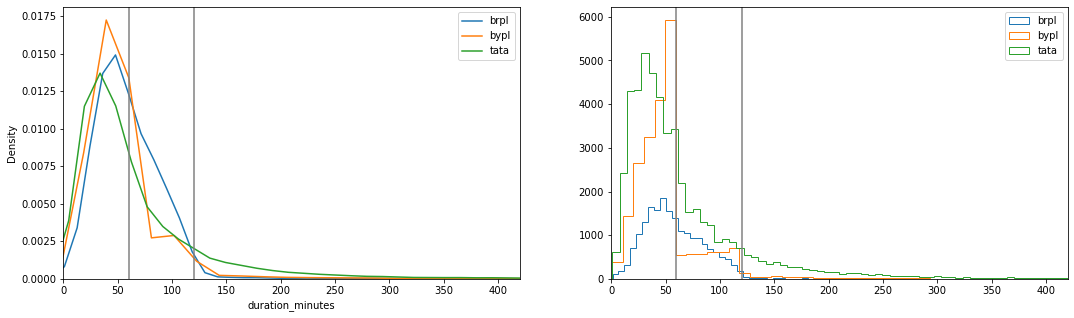

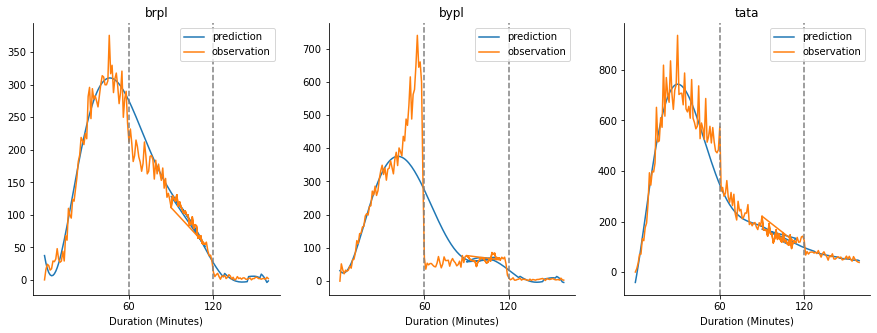

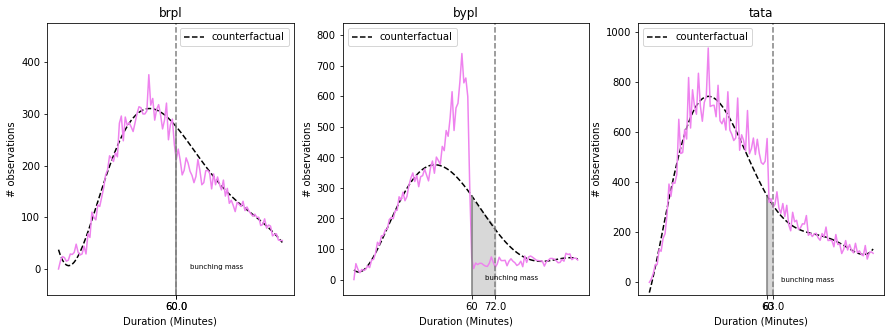

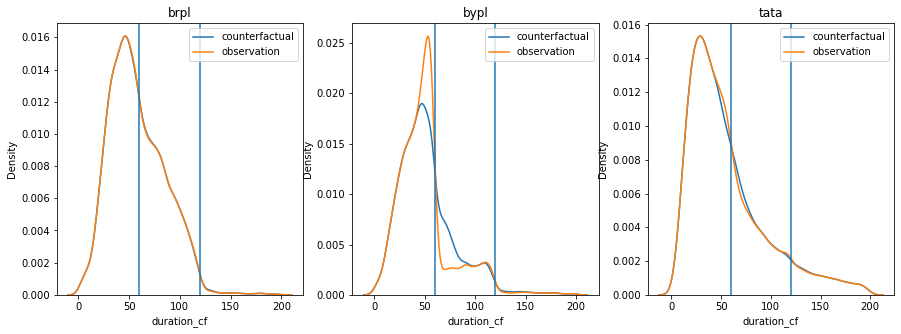

In [1]:
import tools
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from sympy import symbols
from scipy.optimize import fsolve
import seaborn as sns
import numpy as np
from lmfit import Parameters, fit_report, minimize
!jupyter nbconvert --to script outage_bunching.ipynb 
# converts notebook to py file needed to import results from bunching
from outage_bunching import bunching
#import outage_bunching

np.random.seed(111)

In [3]:
wd = Path.cwd()
data = pd.read_csv(wd.parent/'data'/'data_transformed'/'outage_bunch.csv')

data.head()

C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,division_name,id,area_affected,noofcustomersaffected,capacity,duration,unservedmuduetooutage,remarks,date,end_date,...,school,hospital,dairy,residential,minute_of_day,q,quarter,hourly,year,duration_cf
0,alaknanda,1.0,"part off dsidc okhla phase‐1,",312.0,other outage,0:43,0.000005,outage due to\nfault,2019-12-02 00:00:00,2019-12-02 00:00:00,...,0.0,0.0,0.0,0.0,31.0,3.0,49898.0,16993.0,2019.0,43.0
1,alaknanda,2.0,"part off indira kalyan vihar okhla phase‐1,",314.0,other outage,0:09,0.000017,outage due to\nfault,2019-12-03 00:00:00,2019-12-03 00:00:00,...,0.0,0.0,0.0,0.0,30.0,3.0,49924.0,17003.0,2019.0,9.0
2,alaknanda,3.0,"part off b‐block kalka ji,e‐block kalka ji,f‐b...",303.0,other outage,0:57,0.000633,outage due to fault,2019-12-05 00:00:00,2019-12-05 00:00:00,...,0.0,0.0,0.0,0.0,19.0,2.0,50008.0,17036.0,2019.0,57.0
3,alaknanda,4.0,"part off railway yard,",302.0,other outage,0:37,0.000319,outage due to\nfault,2019-12-06 00:00:00,2019-12-06 00:00:00,...,0.0,0.0,0.0,0.0,21.0,2.0,50072.0,17060.0,2019.0,37.0
4,alaknanda,5.0,"part off cng station okhla phase‐1,a‐block okh...",140.0,other outage,0:33,0.000413,outage due to fault,2019-12-06 00:00:00,2019-12-06 00:00:00,...,0.0,0.0,0.0,0.0,30.0,3.0,50063.0,17057.0,2019.0,33.0


$\pi$: revenue loss from outage

Calculation: \
$r =$ unserved kWh / duration of outage \
$\pi = r * tariff$

unserved kWh is a function of the number of customers affected and the duration of the outage

median pi: 44.44444444444444
0.8333333333333334 1.6666666666666667


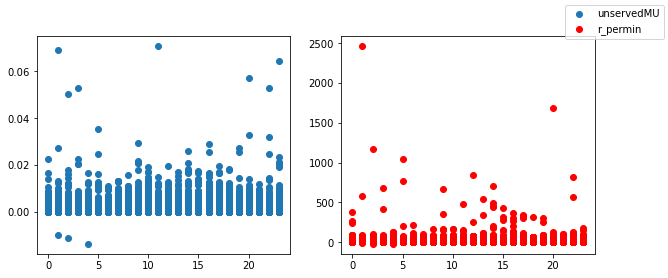

In [4]:
## calculate pi 

#the tariff is a price per kwh
tariff = 8

data['r_permin'] = data.apply(lambda row: row.unservedmuduetooutage * 1e6 / row.duration_minutes, axis = 1)

data['pi'] = data.r_permin * tariff

pi = data.pi.median()

print('median pi:', pi)



# define parameters 
phi = 50/60 
phi120 = 100/60
print(phi, phi120)

#sns.kdeplot(data.r_permin)

# 
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(data.hour_of_day, data.unservedmuduetooutage, label = 'unservedMU')
ax[1].scatter(data.hour_of_day, data.r_permin, label='r_permin', color='red')
fig.legend()

#data.r_permin.describe()

## model estimation : alpha

non-linear least squares

$ (\frac{\pi + \phi}{\pi}) (\frac{x}{x + \Delta x}) = \frac{1}{\alpha} [(\frac{\pi + \phi}{\phi})^{\alpha / 1+\alpha} (1+\alpha) - (1 + \frac{\Delta x}{x})^{\alpha}]$

In [5]:
data.discom.unique()

array(['brpl', 'bypl', 'tata'], dtype=object)

In [7]:
# code source: https://lmfit.github.io/lmfit-py/fitting.html


pars = Parameters()
pars.add('alpha', value = .8)

alphas = {}
# for each firm separately
for f in data.discom.unique():
    dt = data[(data.discom == f) & (data.pi >0)]# keep only non-negative values
    dx60 = bunching[f]['bunch60'].total_bunch()

    def residual(pars,pi, data ,phi = phi, x = 60, dx = dx60):
        vals = pars.valuesdict()
        alpha = vals['alpha']
        # RHS of equation
        model = 1/alpha * (((pi + phi)/phi)**(alpha /(1+alpha)) * (1+alpha) - (1 + (dx/ x))**alpha )
        return model - data


    # calculate left side of equation
    left = dt.apply(lambda row: (row.pi + phi) / row.pi * 60/(60+dx60) , axis = 1 ).to_numpy()
    fit_params = Parameters()
    fit_params.add('alpha', value = .5)
    # fit model
    out = minimize(residual, fit_params, args = (dt.pi.to_numpy() ,left))
    #print(fit_report(out)) # output
    alphas[f] = {'output':out,'value': out.params['alpha'].value, 'std':out.params['alpha'].stderr}

print(alphas)

{'brpl': {'output': <lmfit.minimizer.MinimizerResult object at 0x0000019C9E238C10>, 'value': -0.8417725375860663, 'std': 0.0020400840003333164}, 'bypl': {'output': <lmfit.minimizer.MinimizerResult object at 0x0000019C9E24C730>, 'value': -0.9740162957136542, 'std': 0.00023413646942533798}, 'tata': {'output': <lmfit.minimizer.MinimizerResult object at 0x0000019C9964F1F0>, 'value': -0.963392760663255, 'std': 0.0015921452097029582}}


In [9]:
for f in data.discom.unique():
    out = alphas[f]['output']
    print(f'---------{f}----------------------')
    print('Parameter    Value       Stderr')
    for name, param in out.params.items():
        print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')


---------brpl----------------------
Parameter    Value       Stderr
alpha      -0.84177     0.00204
---------bypl----------------------
Parameter    Value       Stderr
alpha      -0.97402     0.00023
---------tata----------------------
Parameter    Value       Stderr
alpha      -0.96339     0.00159


In [12]:
# create new column alpha and assign values
data['alpha'] = 0
for f in data.discom.unique():
    alpha = alphas[f]['value']
    data.loc[data.discom == f, 'alpha'] = alpha

## calculate the $\sigma$'s based on the counterfactual x's and alpha's

In [17]:
data['sigma'] = 0

def get_sigma(s,x, N, pi, alpha):
    if x < 60:
        exp = tools.xopt(s, pi, phi=0, alpha = alpha, N=N) - x
    elif x < 120:
        exp = tools.xopt(s, pi, phi=50/60, alpha = alpha, N=N) - x
    else:   
        exp = tools.xopt(s, pi, phi=100/60, alpha = alpha, N=N) - x
    return exp

for i in data.index:
    s = symbols('s')
    x = data.loc[i, 'duration_cf']
    N = data.loc[i, 'noofcustomersaffected']
    pi = data.loc[i, 'pi']
    alp = data.loc[i,'alpha']
    data.loc[i,'sigma'] = fsolve(get_sigma, x0 = 10, args = (x, N, pi, alp))[0]


C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paula\OneDrive\Documents\400_VWL\420 Work\Dana\Dehli_outages\src\tools.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  return sigma * ((pi + phi*N))**(-1/(1+alpha))


count    9.123000e+04
mean     1.288230e+06
std      2.587004e+07
min      7.388960e-22
25%      1.000000e+01
50%      1.000000e+01
75%      1.000000e+01
max      1.014594e+09
Name: sigma, dtype: float64

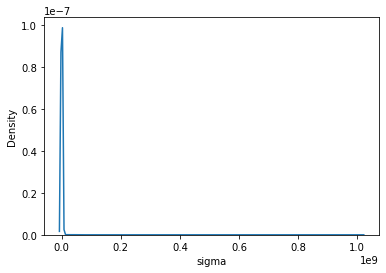

In [18]:
sns.kdeplot(x = data.sigma)
#plt.xlim(-1000,20000)
data.sigma.describe()


In [19]:
# export 
data.to_csv(wd.parent/'data'/'data_transformed'/'outage_bunch_est.csv', index=False)

# Alternative calculation of alpha



solve for $\alpha$ and compare: $K(x^I) = K(x^*)$

$K(x^I) = (\pi + \phi)^{\alpha /1+\alpha} (x^* + \Delta x^*) \pi^{1/1+\alpha}  (1 + 1/\alpha)$


at $x$ around $60$: $\phi = 50$

If $x>120$: $\phi = 100$


I am now doing it for N=1, not sure if that's right. Also, we should double check the functions. What values of $\pi$ and $\phi$ should we use? For $\pi$ we could maybe do a weighted average

alpha: 5.925371436624084 deltax 4.303755439887405
alpha: 5.283274454191148 deltax 1.0355002865033742


c:\Users\paula\OneDrive\Documents\400_VWL\420 Work\Dana\Dehli_outages\src\tools.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  first = sigma / alpha
<ipython-input-28-9f8946c7dab8>:25: RuntimeWarning: invalid value encountered in double_scalars
  return L(a) - R(a)


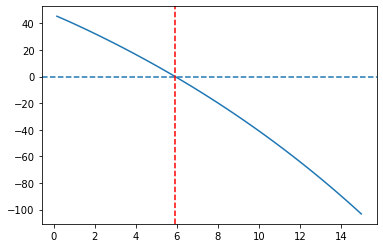

In [28]:
alpha60 = tools.solve_alpha(60, bunch60.total_bunch(), pi, phi=50/60, phi120 = 100/60, startingvalue = 10)
alpha120 = tools.solve_alpha(120, bunch120.total_bunch(), pi, phi=50/60, phi120 = 100/60, startingvalue=10)

print('alpha:',alpha60, 'deltax', bunch60.total_bunch())
print('alpha:',alpha120, 'deltax', bunch120.total_bunch())

alpha = alpha60
#alpha = 0.8

# plot indifference as a function of alpha
delta_x = bunch60.total_bunch()
def sigmaI(a):
    return (60 + delta_x)*(pi)**(1/(1+a))

def  xI(a):
    return  sigmaI(a) * (pi+50/60)**(-1/(1+a))

def L(a):
    return tools.K(xI(a), sigmaI(a), pi=pi, phi=50/60, phi120 = 100/60,alpha=a, N=1)
    
def R(a):
    return pi*60 + tools.C(60, sigmaI(a), a) 

def solution(a):
    return L(a) - R(a)

alphas = np.linspace(0,15, 100)
sol =  [solution(a) for a in alphas]
plt.plot(alphas,sol)
plt.axhline(0, linestyle = 'dashed')
plt.axvline(alpha60, linestyle='dashed', color = 'red')